$$
\newcommand{\bx}{\mathbf{x}}
\newcommand{\bxi}{\mathbf{x}^{(i)}}
\newcommand{\bxid}{\mathbf{x}_d^{(i)}}
\newcommand{\si}{s^{(i)}}
\newcommand{\bv}{\mathbf{v}}
\newcommand{\by}{\mathbf{y}}
\newcommand{\bz}{\mathbf{z}}
\newcommand{\E}{\mathbb{E}}
\newcommand{\V}{\mathbb{V}}
\newcommand{\R}{\mathbb{R}}
\newcommand{\calN}{\mathcal{N}}
\newcommand{\tr}{\textrm{Tr}}
\newcommand{\expect}[1]{\langle {#1} \rangle}
$$

## 2D Mixture of Bernoullis EM Demo

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set(style="white", color_codes=True)

### Prepare data

In [2]:
A = np.loadtxt("../data/binarydigits.txt")
A = np.asarray(A)

In [3]:
N, D = A.shape

### EM optimisation

We model a given binary data vector as a mixture:

\begin{align}
    s &\sim \textrm{Discrete}[\pi] \\
    \bx \mid s = k &= \prod_d P(\bx_d \mid \Lambda_{kd}) = \prod_d \Lambda_{kd}^{\bx_d}(1-\Lambda_{kd})^{1-{\bx_d}}
\end{align}

The log-joint is given by

\begin{align}
    \log \prod_i P(\bx_i, s_i \mid \pi, \Lambda) &= \log \prod_i \prod_k [P(\si=k) \prod_d P(\bxid \mid \si=k)]^{I[\si = k]} \\
    &= \log \prod_i \prod_k [\pi_k \prod_d \Lambda_{kd}^{\bxid}(1-\Lambda_{kd})^{1-{\bxid}}]^{I[\si = k]} \\
    &= \sum_i \sum_k I[\si = k] (\log \pi_k + \sum_d \bxid \log \Lambda_{kd} + (1 - \bxid)\log(1-\Lambda_{kd})) 
\end{align}

Therefore the expectations we will need in the E-step are of $I[\si=k]$ under the posterior $P(\si \mid \bxi)$.

\begin{align}
    P(\si=k \mid \bxi) &\propto P(\bxi, \si=k) = \frac{P(\bxi, \si=k)}{\sum_k' P(\bxi, \si=k')} \\
    &\Rightarrow \gamma_{ik} = \expect{I[\si=k]}_{P(\si=k \mid \bxi)} = P(\si=k \mid \bxi)
\end{align}

The expected log-joint under the full posterior (which is separable) is then

\begin{equation}
    \sum_i \sum_k r_{ik} (\log \pi_k + \sum_d \bxid \log \Lambda_{kd} + (1 - \bxid)\log(1-\Lambda_{kd})) 
\end{equation}

M-step updates are then

\begin{align}
    \pi_k &= \frac{1}{N}\sum_i r_{ik} \\
    \Lambda_{kd} &= \frac{1}{\sum_i r_{ik}}\sum_i r_{ik}\bxid \\
\end{align}

In [4]:
def initial_parameters(D, K):
    mixings = np.random.random(K)
    mixings /= np.sum(mixings)
    
    L = np.random.random((K, D))

    return mixings, L

In [5]:
def E(data, *old_params):
    mixings, L = old_params
    
    bernoulli_lls = np.power(L, data[:, None, :]) * np.power((1.0-L), (1-data[:, None, :])) # N x K x D
    bernoulli_lls_prod = np.prod(bernoulli_lls, axis=-1)  # N x K
    joints = bernoulli_lls_prod * mixings  # N x K
    posteriors = joints / np.sum(joints, axis=1)[:, None]  # N x K
    
    return {"responsibilities": posteriors}

In [6]:
def M(data, *old_params, **expectations):
    old_mixings, old_L = old_params
    responsibilities = expectations["responsibilities"]
    
    total_responsibilities = np.sum(responsibilities, axis=0)

    mixings = total_responsibilities / N
    L = responsibilities.T @ data / total_responsibilities[:, None]
    
    return mixings, L

In [7]:
def loglikelihood(data, *params):
    mixings, L = params
    
    bernoulli_lls = np.power(L, data[:, None, :]) * np.power((1.0-L), (1-data[:, None, :])) # N x K x D
    bernoulli_lls_prod = np.prod(bernoulli_lls, axis=-1)  # N x K
    joints = bernoulli_lls_prod * mixings  # N x K
    ll = np.sum(np.log(np.sum(joints, axis=1)))
    
    return ll

In [8]:
def run(K, num_iters=30, stopping_criterion=1e-6):
    lls = []
    old_ll = -1e6
    
    mixings, L = initial_parameters(D, K)
    
    for _ in range(num_iters):
        ll = loglikelihood(A, mixings, L)
        if abs((ll - old_ll) / ll) <= stopping_criterion:
            break
        lls.append(ll)
        old_ll = ll
        
        expectations = E(A, mixings, L)
        mixings, L = M(A, mixings, L, **expectations)
    
    return lls

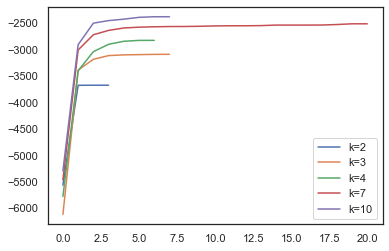

In [9]:
ks = [2, 3, 4, 7, 10]
for k in ks:
    plt.plot(run(k))
plt.legend(["k=%s"% k for k in ks])
plt.show()